In [1]:
### by lneufcourt
### adapted from https://github.com/Joseph94m/MCMC/blob/master/MCMC.ipynb

In [2]:
import numpy as np
import scipy
import scipy.stats
# import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(2019)

# Data generation

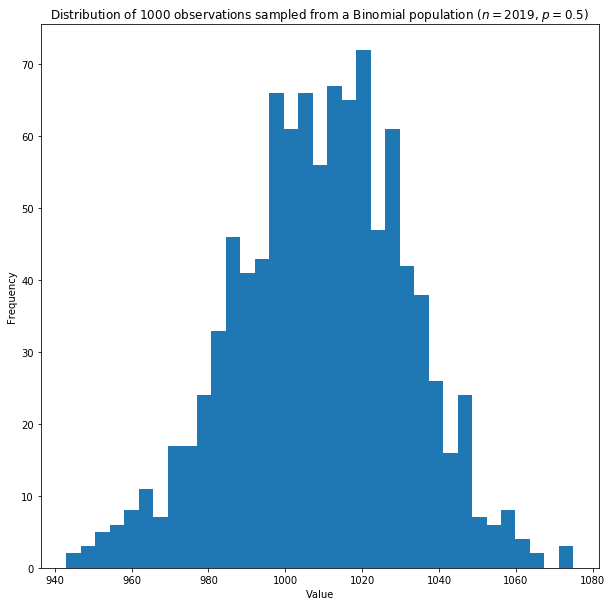

In [4]:
def generate_iid_binomial_data(n = 2019, p = .5, n_data = 1):
    return np.random.binomial(n, p, n_data)

X = generate_iid_binomial_data(n_data = 1000)

fig, ax = plt.subplots(figsize = (10,10))
ax.hist(X, bins = 35)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of 1000 observations sampled from a Binomial population ($n = 2019$, $p=0.5$)")
plt.show()


# Metropolis(-Hastings) sampling

In [5]:
def uniform_prior(n):
    """
        n: integer
        
        returns global probability p(N = n), uniform on positive integers
    """
    if(n <= 0): r = 0
    else: r = 1
    return r

def house_prior(n):
    """
        x: integer
        
        returns global probability p(N = n), proportional to 1 / n^2
    """
    return np.pi**2 / (6 * n**2)

def log_likelihood(n, data):
    """
        n: integer
        
        returns log-likelihood p(X = data | N = n)
    """
    return np.sum(scipy.stats.binom.logpmf(data, n, .5))

def transition_uniform(n, max_jump = 100):
    """
        x: integer, current state of Markov chain
        max_jump: integer
        
        returns a (random) sample obtained in one transition from x of the Markov chain 
        defined with p_{i,j} = 1_{|j - i| <= max_jump} / (2 * max_jump) 
        which is the transition matrix of a recurrent aperiodic Markov chain 
    """
    return np.random.randint(max(n - max_jump, 0), n + max_jump)

def acceptance(x, x_new):
    """
        x: last Markoc chain sample
        x_new: new sample candidate from proposal distribution
        
        returns a (random) boolean indicating whether the x_new should be accepted or rejected
    """
    if x_new > x: r = True
    else:
        accept = np.random.uniform(0,1)
        r = (accept < (np.exp(x_new - x)))
    return r


def metropolis_hastings(likelihood_computer, prior, transition_model, param_init, iterations, data, acceptance_rule):
    """
        likelihood_computer: function (x, data) --> likelihood of the model p(data | x)
        transition_model: function (x) --> sample x_new from a proposal distribution Q(x, x_new), 
                                           for any aperiodic recurrent transition matrix Q
        param_init: initial value for the Markov chain  
        iterations: number of algorithm iterations 
        data: data x following the likelihood model p(data | x)
        acceptance_rule: function(x, x_new) --> boolean indicating decision whether to accept the new sample x_new
    """
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance(x_lik + np.log(prior(x)), x_new_lik + np.log(prior(x_new)))):   
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
    return np.array(accepted), np.array(rejected)


In [6]:
# running the algorithm
accepted, rejected = metropolis_hastings(log_likelihood, house_prior, transition_uniform, 1000, 10000, X, acceptance)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars


In [7]:
# latest accepted values
accepted[-10:]

array([2018, 2016, 2016, 2018, 2018, 2018, 2017, 2017, 2018, 2018])

In [8]:
# latest rejected values
rejected[-10:]

array([2082, 2114, 1969, 1950, 2006, 2105, 2062, 2105, 2060, 2035])

In [9]:
# proportion of accepted samples
len(accepted) / (len(accepted) + len(rejected))


0.025

(250,)

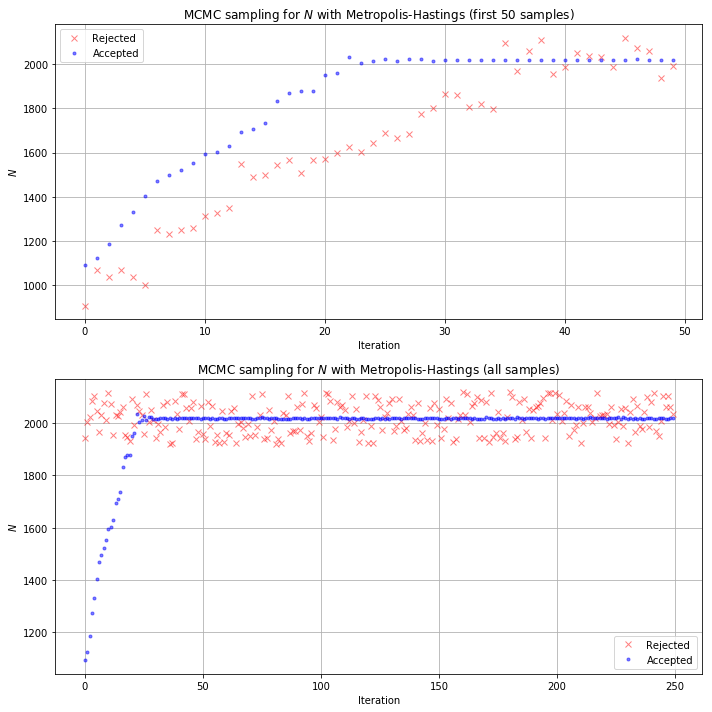

In [10]:
# path of the MCMC samples 

fig, axes = plt.subplots(2, 1, figsize = (10,10))

axes[0].plot(rejected[0:50], 'rx', label = 'Rejected', alpha = 0.5)
axes[0].plot(accepted[0:50], 'b.', label = 'Accepted', alpha = 0.5)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("$N$")
axes[0].set_title("MCMC sampling for $N$ with Metropolis-Hastings (first 50 samples)")
axes[0].grid()
axes[0].legend()

show = -len(accepted)
axes[1].plot(rejected[show:], 'rx', label = 'Rejected', alpha = 0.5)
axes[1].plot(accepted[show:], 'b.', label = 'Accepted', alpha = 0.5)
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("$N$")
axes[1].set_title("MCMC sampling for $N$ with Metropolis-Hastings (all samples)")
axes[1].grid()
axes[1].legend()

fig.tight_layout()
accepted.shape

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


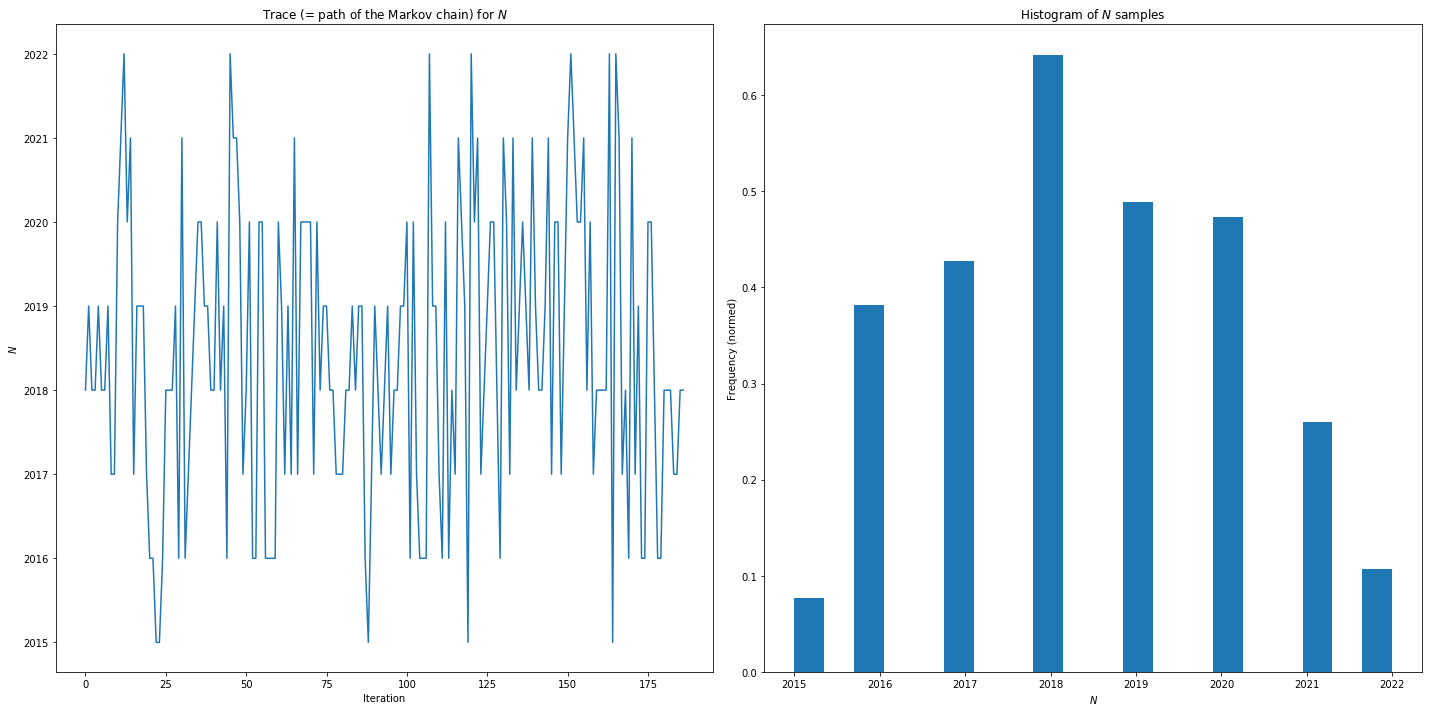

In [11]:
# distribution of the MCMC samples 

fig, axes = plt.subplots(1, 2, figsize = (20,10))
show = int(-0.75 * accepted.shape[0])

axes[0].plot(accepted[show:])
axes[0].set_title("Trace (= path of the Markov chain) for $N$")
axes[0].set_ylabel("$N$")
axes[0].set_xlabel("Iteration")

axes[1].hist(accepted[show:], bins = 20,density=True)
axes[1].set_ylabel("Frequency (normed)")
axes[1].set_xlabel("$N$")
axes[1].set_title("Histogram of $N$ samples")
fig.tight_layout()
axes[1].grid("off")
plt.show()


# Estimating the conditional expectation

In [12]:
# the expectation is given by the average of the sample values
# once the chain have reached its stationary distribution
# in practice, burn-in the first 'non-stationary' part of the samples 

accepted[-int(.5 * len(accepted))].mean()

2017.0

In [13]:
# as expected, we almost recover the true value of the parameter N that was used to generate the data
# since we have used a non-uniform prior P(N = n) that decreases with n, we obtain a value slightly biased towards 
# lower values of n